## Exploration 5. 트랜스포머로 만드는 대화형 챗봇

# Project '한국어 데이터로 챗봇 만들기'
- 영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련진행

**[노드 학습내용]**

- encoder, decoder 개념
- Transformer 입력방식 - positionalencoding layer
- attention mechanism
    - Scaled dot-product attention
    - Multi-head attention
- Transformer maskings - Padding Masking, Look ahead Masking
- Transformer 구조 설계
- 데이터셋 준비 - 병렬 데이터 전처리, 교사강요
- 트랜스포머 모델을 통한 챗봇 테스트


**[진행과정]**
1. Step 1. 데이터 준비
2. Step 2. 트랜스포머 모델 구현
3. Step 3. 모델 훈련
4. Step 4. 모델 테스트


In [1]:
# tensorflow version check
import tensorflow as tf
print(tf.__version__)

2.6.0


In [74]:
# import libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

---

# ===STEP 1. 데이터 준비===

# Dataset
**송영숙님이 공개한 한국어 챗봇 데이터** <br>
[다운도르 링크:songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

- [Korpora](https://ko-nlp.github.io/Korpora/ko-docs/introduction/quicktour.html)를 참고해서 데이터 로드

In [ ]:
# # prepare dataset directory 
# ! mkdir -p ~/aiffel/transformer_chatbot/data/
# ! ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

In [2]:
# # download package
# !pip install Korpora

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 3.8 MB/s eta 0:00:00


In [4]:
# prepare dataset directory 
# 현재 주피터 노트북이 실행 중인 디렉토리를 가져옴
import os

current_directory = os.getcwd()
print(current_directory)

/Users/seullee/Documents/STUDY-AI/AIFFEL/Aiffel_home/Exploration/Ex05


In [5]:
# 데이터셋을 저장할 경로 설정 (현재 디렉토리 기준으로 상대 경로로 설정)
data_path = os.path.join(current_directory, 'transformer_chatbot')

# 경로가 존재하지 않는 경우, 해당 경로를 생성
if not os.path.exists(data_path):
    os.makedirs(data_path)

print(data_path)

/Users/seullee/Documents/STUDY-AI/AIFFEL/Aiffel_home/Exploration/Ex05/transformer_chatbot


In [8]:
# download data
# Korpora package중에서 송영숙님 챗봇데이터  'korean_chatbot_data'만 사용
import requests
from Korpora import Korpora

corpus = Korpora.fetch("korean_chatbot_data", root_dir=data_path)

HTTPError: HTTP Error 404: Not Found

- url을 읽어오는 부분에서 에러가 생기는것같다. (참고-[stackoverflow](https://stackoverflow.com/questions/42441211/python-urllib-error-httperror-http-error-404-not-found))
- 터미널 명령어로 시도

In [9]:
Korpora.corpus_list()

{'kcbert': 'beomi@github 님이 만드신 KcBERT 학습데이터',
 'korean_chatbot_data': 'songys@github 님이 만드신 챗봇 문답 데이터',
 'korean_hate_speech': '{inmoonlight,warnikchow,beomi}@github 님이 만드신 혐오댓글데이터',
 'korean_parallel_koen_news': 'jungyeul@github 님이 만드신 병렬 말뭉치',
 'korean_petitions': 'lovit@github 님이 만드신 2017.08 ~ 2019.03 청와대 청원데이터',
 'kornli': 'KakaoBrain 에서 제공하는 Natural Language Inference (NLI) 데이터',
 'korsts': 'KakaoBrain 에서 제공하는 Semantic Textual Similarity (STS) 데이터',
 'kowikitext': 'lovit@github 님이 만드신 wikitext 형식의 한국어 위키피디아 데이터',
 'namuwikitext': 'lovit@github 님이 만드신 wikitext 형식의 나무위키 데이터',
 'naver_changwon_ner': '네이버 + 창원대 NER shared task data',
 'nsmc': 'e9t@github 님이 만드신 Naver sentiment movie corpus v1.0',
 'question_pair': 'songys@github 님이 만드신 질문쌍(Paired Question v.2)',
 'modu_news': '국립국어원에서 만든 모두의 말뭉치: 뉴스 말뭉치',
 'modu_messenger': '국립국어원에서 만든 모두의 말뭉치: 메신저 말뭉치',
 'modu_mp': '국립국어원에서 만든 모두의 말뭉치: 형태 분석 말뭉치',
 'modu_ne': '국립국어원에서 만든 모두의 말뭉치: 개체명 분석 말뭉치',
 'modu_spoken': '국립국어원에서 만든 모두의 말뭉치: 구어 

In [15]:
!korpora fetch --corpus korean_chatbot_data --root_dir $PROJECT_DATA

usage: korpora [-h] {fetch,list,lmdata} ...
korpora: error: unrecognized arguments: --root_dir


In [16]:
from Korpora import KoreanChatbotKorpus
corpus = KoreanChatbotKorpus(root_dir=data_path)


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : songys@github
    Repository : https://github.com/songys/Chatbot_data
    References :

    Chatbot_data_for_Korean v1.0
      1. 챗봇 트레이닝용 문답 페어 11,876개
      2. 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
    자세한 내용은 위의 repository를 참고하세요.

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/



HTTPError: HTTP Error 404: Not Found

---

❤️‍🔥 민기님 도움을 받아서 주소를 이용해서 데이터를 다운로드

In [1]:
# 데이터프레임에 담기
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [2]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


데이터프레임에 Q, A, label이 담겨있다.

- 깃헙 data description 정보는 아래와 같다

> 챗봇 트레이닝용 문답 페어 11,876개 => 데이터 수정이 있나보다 : **11,823개**<br>
> label : 일상다반사=0, 이별(부정)=1, 사랑(긍정)=2

In [3]:
# 빈 데이터가 있는지 확인
print(df.isnull().sum())

Q        0
A        0
label    0
dtype: int64


---

# EDA 
[REF] [텐서플로2와 머신러닝으로 시작하는 자연어처리](https://arc.net/l/quote/lbrgynnm), [데이터사이언스스쿨-KoNLPy 한국어 처리 패키지](https://datascienceschool.net/03%20machine%20learning/03.01.02%20KoNLPy%20%ED%95%9C%EA%B5%AD%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html)
- 내가 필요한 데이터는 Q, A 데이터이니 label은 제외하고 노드에서 학습했던 함수를 사용할수 있도록 sentence형태의 데이터로 만든다
- KoNLPy 패키지를 활용해 한국어 형태소 분석 라이브러리를 사용할예정

---

💡
## KoNLPy 형태소분석 라이브러리
- Hannanum: 한나눔. KAIST Semantic Web Research Center 개발
    - http://semanticweb.kaist.ac.kr/hannanum/
- Kkma: 꼬꼬마. 서울대학교 IDS(Intelligent Data Systems) 연구실 개발
    - http://kkma.snu.ac.kr/
- Komoran: 코모란. Shineware에서 개발.
    - https://github.com/shin285/KOMORAN
- Mecab: 메카브. 일본어용 형태소 분석기를 한국어를 사용할 수 있도록 수정.
    - https://bitbucket.org/eunjeon/mecab-ko
- Open Korean Text: 오픈 소스 한국어 분석기. 과거 트위터 형태소 분석기.
    - https://github.com/open-korean-text/open-korean-text
    

    -> 이 중에서 OKT를 사용

In [4]:
import warnings
warnings.simplefilter("ignore")

import konlpy
konlpy.__version__

'0.5.2'

In [5]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

from konlpy.tag import Okt

In [6]:
# sentence 추출
sentences = list(df['Q']) + list(df['A'])
sentences[:3]

['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다']

- 문장들을 토큰화하고 어절, 형태소, 음절의 길이를 확인
    - 이 부분은 '텐서플로2와 머신러닝으로 시작하는 자연어처리' 책 내용을 참고

**[기본정보]**
- 어절 : 문장성분의 최소 단위 - 띄어쓰기의 단위로 쓴다
- 음절 : 발음하는대로 한 글자씩 - 한국어를 발음할때 한 번에 소리낼수 있는 소리의 마디
- 형태소 : 뜻을 가진 가장 작은 말의 단위 - 품사에 따라 분석

In [7]:
# 문장 토큰화
tokenized_sentences = [s.split() for s in sentences]
# 토큰(어절) 길이
sent_len_by_token = [len(t) for t in tokenized_sentences]
# 음절 길이 
sent_len_by_eumjeol = [len(s.replace(' ', '')) for s in sentences]

okt = Okt()
# 형태소 토큰화
morph_tokenized_sentences = [okt.morphs(s.replace(' ', '')) for s in sentences]
# 형태소 길이
sent_len_by_morph = [len(t) for t in morph_tokenized_sentences]

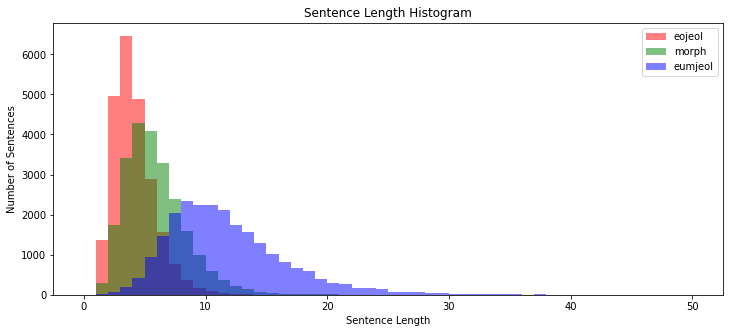

In [13]:
# 문장 길이 시각화
plt.figure(figsize=(12, 5))
plt.hist(sent_len_by_token, bins=50, range=[0,50], alpha=0.5, color= 'r', label='eojeol')
plt.hist(sent_len_by_morph, bins=50, range=[0,50], alpha=0.5, color='g', label='morph')
plt.hist(sent_len_by_eumjeol, bins=50, range=[0,50], alpha=0.5, color='b', label='eumjeol')

# Adding title and labels
plt.title('Sentence Length Histogram')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')

# Displaying legend
plt.legend()

# Display the plot
plt.show()

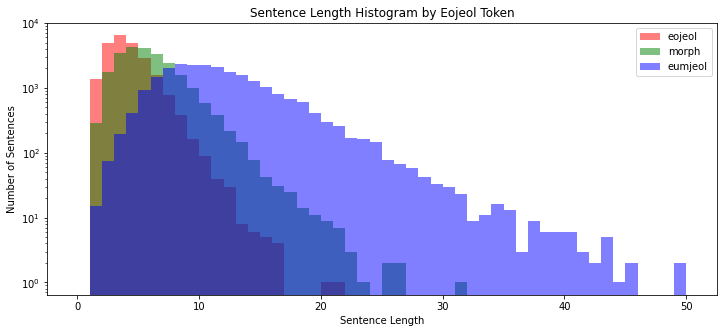

In [14]:
# 음절토큰을 기준으로 문장길이 시각화
plt.figure(figsize=(12, 5))
plt.hist(sent_len_by_token, bins=50, range=[0,50], alpha=0.5, color= 'r', label='eojeol')
plt.hist(sent_len_by_morph, bins=50, range=[0,50], alpha=0.5, color='g', label='morph')
plt.hist(sent_len_by_eumjeol, bins=50, range=[0,50], alpha=0.5, color='b', label='eumjeol')

# Scaling the y-axis logarithmically for better visualization
plt.yscale('log')

# Adding title and labels
plt.title('Sentence Length Histogram by Eojeol Token')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')

# Displaying legend
plt.legend()

# Display the plot
plt.show()

- 와 뭔가 그래프가 많이 나왔는데 정확하게 음절과 토큰의 개념이 아직 정리가 잘 안되어서인지 어떤 의미인지 알기가 어렵다

In [10]:
# 토큰(어절) 정보 출력
print('어절 최대길이: {}'.format(np.max(sent_len_by_token)))
print('어절 최소길이: {}'.format(np.min(sent_len_by_token)))
print('어절 평균길이: {:.2f}'.format(np.mean(sent_len_by_token)))
print('어절 길이 표준편차: {:.2f}'.format(np.std(sent_len_by_token)))
print('어절 중간길이: {}'.format(np.median(sent_len_by_token)))
print('제 1 사분위 길이: {}'.format(np.percentile(sent_len_by_token, 25)))
print('제 3 사분위 길이: {}'.format(np.percentile(sent_len_by_token, 75)))

어절 최대길이: 21
어절 최소길이: 1
어절 평균길이: 3.64
어절 길이 표준편차: 1.74
어절 중간길이: 3.0
제 1 사분위 길이: 2.0
제 3 사분위 길이: 5.0


In [11]:
# 형태소 정보 출력
print('형태소 최대길이: {}'.format(np.max(sent_len_by_morph)))
print('형태소 최소길이: {}'.format(np.min(sent_len_by_morph)))
print('형태소 평균길이: {:.2f}'.format(np.mean(sent_len_by_morph)))
print('형태소 길이 표준편차: {:.2f}'.format(np.std(sent_len_by_morph)))
print('형태소 중간길이: {}'.format(np.median(sent_len_by_morph)))
print('형태소 1/4 퍼센타일 길이: {}'.format(np.percentile(sent_len_by_morph, 25)))
print('형태소 3/4 퍼센타일 길이: {}'.format(np.percentile(sent_len_by_morph, 75)))

형태소 최대길이: 31
형태소 최소길이: 1
형태소 평균길이: 5.41
형태소 길이 표준편차: 2.56
형태소 중간길이: 5.0
형태소 1/4 퍼센타일 길이: 4.0
형태소 3/4 퍼센타일 길이: 7.0


In [12]:
# 음절 정보 출력
print('음절 최대길이: {}'.format(np.max(sent_len_by_eumjeol)))
print('음절 최소길이: {}'.format(np.min(sent_len_by_eumjeol)))
print('음절 평균길이: {:.2f}'.format(np.mean(sent_len_by_eumjeol)))
print('음절 길이 표준편차: {:.2f}'.format(np.std(sent_len_by_eumjeol)))
print('음절 중간길이: {}'.format(np.median(sent_len_by_eumjeol)))
print('음절 1/4 퍼센타일 길이: {}'.format(np.percentile(sent_len_by_eumjeol, 25)))
print('음절 3/4 퍼센타일 길이: {}'.format(np.percentile(sent_len_by_eumjeol, 75)))

음절 최대길이: 57
음절 최소길이: 1
음절 평균길이: 11.31
음절 길이 표준편차: 4.98
음절 중간길이: 10.0
음절 1/4 퍼센타일 길이: 8.0
음절 3/4 퍼센타일 길이: 14.0


✅ 지난번 프로젝트때 이 길이와 표준편차, percentile 정보를 활용해서 데이터 전처리했던것 같다. 이 부분을 다시 체크필요!

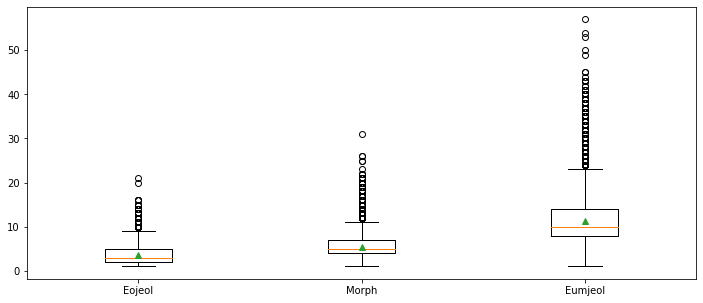

In [16]:
# boxplot
plt.figure(figsize=(12, 5))
plt.boxplot([sent_len_by_token, sent_len_by_morph, sent_len_by_eumjeol],
            labels=['Eojeol', 'Morph', 'Eumjeol'], 
            showmeans=True)
plt.show()

- 대략적으로 길이 0~10 정도 분포를 가진걸 의미하는것 같다

---

질문과 대답 데이터셋을 나누어서 확인

In [18]:
# 질문 문장 데이터
query_sentences = list(df['Q'])

# 대답 문장 데이터
answer_sentences = list(df['A'])

# 질문 형태소 토큰화
query_morph_tokenized_sentences = [okt.morphs(s.replace(' ', '')) for s in query_sentences]
# 질문 형태소 토큰 길이
query_sent_len_by_morph = [len(t) for t in query_morph_tokenized_sentences]

# 대답 형태소 토큰화
answer_morph_tokenized_sentences = [okt.morphs(s.replace(' ', '')) for s in answer_sentences]
# 대답 형태소 토큰 길이
answer_sent_len_by_morph = [len(t) for t in answer_morph_tokenized_sentences]

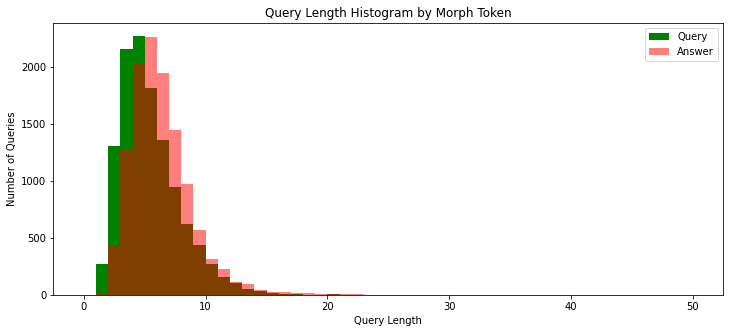

In [19]:
# Setting up the figure size
plt.figure(figsize=(12, 5))

# Plotting histogram for query lengths, answer lengths
plt.hist(query_sent_len_by_morph, bins=50, range=[0,50], color='g', label='Query')
plt.hist(answer_sent_len_by_morph, bins=50, range=[0,50], color='r', alpha=0.5, label='Answer')

# Display legned
plt.legend()

# Adding title and labels
plt.title('Query Length Histogram by Morph Token')
plt.xlabel('Query Length')
plt.ylabel('Number of Queries')

plt.show()

- 질문과 대답 모두 비슷한 분포를 보인다

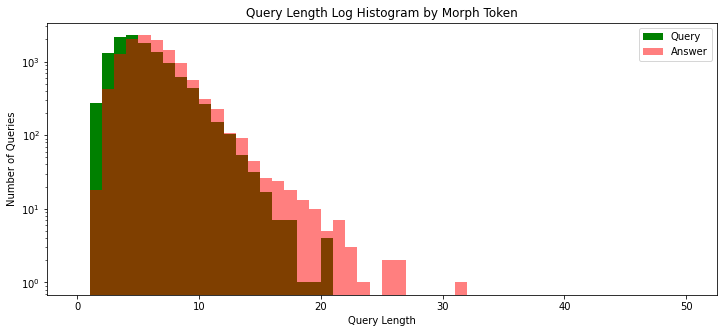

In [20]:
# y axis를 log로 변환한 그래프
plt.figure(figsize=(12, 5))

# Plotting histogram for query lengths, answer lengths
plt.hist(query_sent_len_by_morph, bins=50, range=[0,50], color='g', label='Query')
plt.hist(answer_sent_len_by_morph, bins=50, range=[0,50], color='r', alpha=0.5, label='Answer')

# Displaying legend
plt.legend()

# Applying logarithmic scale to the y-axis
plt.yscale('log', nonposy='clip')
plt.title('Query Length Log Histogram by Morph Token')
plt.xlabel('Query Length')
plt.ylabel('Number of Queries')

plt.show()

## Data preprocessing 1

- **정규 표현식(Regular Expression)** 을 사용해서 구두점(punctuation) 제거
    - 단어 토크나이징(tokenizing)에 방해되지 않도록 정제
    
[REF] [blog](https://velog.io/@jochedda/NLP-%EC%9E%90%EC%97%B0%EC%96%B4-%EC%A0%84%EC%B2%98%EB%A6%AC), [유원준님 깃허브](https://github.com/ukairia777/tensorflow-transformer/blob/main/Transformer_Korean_Chatbot.ipynb)

In [21]:
import re

# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence 양쪽 공백 제거
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리 만들기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (".", "?", "!", ",")와 영어, 한글을 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r'[^\.\?!,-가-힣ㄱ-ㅎㅏ-ㅣ]', ' ', sentence)

    return sentence

In [22]:
# 질문, 답변 데이터 전처리
questions = []
answers = []

for sentence in df['Q']:
    questions.append(preprocess_sentence(sentence))
    
for sentence in df['A']:
    answers.append(preprocess_sentence(sentence))
    
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [24]:
# 15번째 샘플(인덱스 14 샘플) 확인
print('전처리 후의 15번째 질문 샘플: {}'.format(questions[14]))
print('전처리 후의 15번째 답변 샘플: {}'.format(answers[14]))

전처리 후의 15번째 질문 샘플: 가        
전처리 후의 15번째 답변 샘플:               . 


In [25]:
questions[:5]

['12    ! ', '1          ', '3 4    가    ', '3 4       가    ', 'PPL    ']

- 대부분의 단어들이 삭제 된것 같다. 원래 데이터부터 다시 봐야겠다

In [26]:
df['Q'][:5]

0             12시 땡!
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            PPL 심하네
Name: Q, dtype: object

In [27]:
df.head(10)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


In [28]:
# 전처리 함수 2
def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation) 사이의 거리 만들기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (".", "?", "!", ",")와 영어, 한글을 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r'[^a-zA-Z\.\?!,-가-힣ㄱ-ㅎㅏ-ㅣ]', ' ', sentence)

    return sentence

In [29]:
# 질문, 답변 데이터 전처리
questions = []
answers = []

for sentence in df['Q']:
    questions.append(preprocess_sentence(sentence))
    
for sentence in df['A']:
    answers.append(preprocess_sentence(sentence))
    
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [30]:
# 15번째 샘플(인덱스 14 샘플) 확인
print('전처리 후의 15번째 질문 샘플: {}'.format(questions[14]))
print('전처리 후의 15번째 답변 샘플: {}'.format(answers[14]))

전처리 후의 15번째 질문 샘플: 가        
전처리 후의 15번째 답변 샘플:               . 


In [31]:
# 1번째 샘플 확인
print('전처리 후의 1번째 질문 샘플: {}'.format(questions[0]))
print('전처리 후의 1번째 답변 샘플: {}'.format(answers[0]))

전처리 후의 1번째 질문 샘플: 12    ! 
전처리 후의 1번째 답변 샘플:   가   가   . 


- 똑같이 처리된다. strip부분이 문제가 아니라 마지막 대체 부분이 문제인것 같다
- 이 부분 삭제후 다시시도

In [32]:
# 전처리 함수 3
def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation) 사이의 거리 만들기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    return sentence

In [33]:
# 질문, 답변 데이터 전처리
questions = []
answers = []

for sentence in df['Q']:
    questions.append(preprocess_sentence(sentence))
    
for sentence in df['A']:
    answers.append(preprocess_sentence(sentence))
    
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [34]:
# 1번째 샘플 확인
print('전처리 후의 1번째 질문 샘플: {}'.format(questions[0]))
print('전처리 후의 1번째 답변 샘플: {}'.format(answers[0]))

전처리 후의 1번째 질문 샘플: 12시 땡 ! 
전처리 후의 1번째 답변 샘플: 하루가 또 가네요 . 


In [35]:
# 15번째 샘플(인덱스 14 샘플) 확인
print('전처리 후의 15번째 질문 샘플: {}'.format(questions[14]))
print('전처리 후의 15번째 답변 샘플: {}'.format(answers[14]))

전처리 후의 15번째 질문 샘플: 가난한 자의 설움
전처리 후의 15번째 답변 샘플: 돈은 다시 들어올 거예요 . 


- 이제 제대로 되는데 왜 해당 부분 코드가 문제가 됬던거지? 
- 강훈님 도움을 받아 다른 코드로 수정해서 시도

In [36]:
# 전처리 함수 4
def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation) 사이의 거리 만들기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (".", "?", "!", ",")와 영어, 한글을 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r'[^ㄱ-ㅎ가-힣?.!,]+', ' ', sentence)
    return sentence

In [37]:
# 질문, 답변 데이터 전처리
q = []
a = []

for sentence in df['Q']:
    q.append(preprocess_sentence(sentence))
    
for sentence in df['A']:
    a.append(preprocess_sentence(sentence))
    
print('전체 샘플 수 :', len(q))
print('전체 샘플 수 :', len(a))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [38]:
# 1번째 샘플 확인
print('전처리 후의 1번째 질문 샘플: {}'.format(q[0]))
print('전처리 후의 1번째 답변 샘플: {}'.format(a[0]))

전처리 후의 1번째 질문 샘플:  시 땡 ! 
전처리 후의 1번째 답변 샘플: 하루가 또 가네요 . 


In [41]:
# 5번째 샘플 확인
print('전처리 후의 1번째 질문 샘플: {}'.format(q[4]))
print('전처리 후의 1번째 답변 샘플: {}'.format(a[4]))

전처리 후의 1번째 질문 샘플:  심하네
전처리 후의 1번째 답변 샘플: 눈살이 찌푸려지죠 . 


- 숫자, 영어가 비어서 나옴
- 이부분 수정해서 다시 시도

In [42]:
# 전처리 함수 5
def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation) 사이의 거리 만들기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (".", "?", "!", ",")와 영어, 한글을 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r'[^0-9a-zA-Zㄱ-ㅎ가-힣?.!,]+', ' ', sentence)
    return sentence

In [43]:
# 질문, 답변 데이터 전처리
questions = []
answers = []

for sentence in df['Q']:
    questions.append(preprocess_sentence(sentence))
    
for sentence in df['A']:
    answers.append(preprocess_sentence(sentence))
    
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [44]:
# 1번째 샘플 확인
print('전처리 후의 1번째 질문 샘플: {}'.format(questions[0]))
print('전처리 후의 1번째 답변 샘플: {}'.format(answers[0]))

전처리 후의 1번째 질문 샘플: 12시 땡 ! 
전처리 후의 1번째 답변 샘플: 하루가 또 가네요 . 


In [45]:
# 5번째 샘플 확인
print('전처리 후의 1번째 질문 샘플: {}'.format(questions[4]))
print('전처리 후의 1번째 답변 샘플: {}'.format(answers[4]))

전처리 후의 1번째 질문 샘플: PPL 심하네
전처리 후의 1번째 답변 샘플: 눈살이 찌푸려지죠 . 


- 이제 완료!

---

## Data preprocessing 2 - 병렬 데이터 전처리
1. `TensorFlow Datasets SubwordTextEncoder` 를 토크나이저로 사용
   - 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징
   - 각 토큰을 고유한 정수로 인코딩
       - ✅ [tf doc](https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/SubwordTextEncoder) 공부!
   
   
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 **START_TOKEN 및 END_TOKEN을 추가**


3. 최대 길이 **MAX_LENGTH > 40** 문장 필터링
    - 아까 EDA에서 확인했을때 형태소 최대 길이가 31로 나왔지만 토큰을 양 옆에 붙여야하니까 그대로 40으로 맞추면 될것 같다
    
    
4. MAX_LENGTH보다 **길이가 짧은 문장들은 40에 맞도록 패딩**

[REF][wiki docs](https://wikidocs.net/86792)

## 단어장 만들기

In [46]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

In [47]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
# 이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기보다 +1
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [48]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8166]
END_TOKEN의 번호 : [8167]


In [49]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기 계산
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8168


- 숫자가 다르게 나온다... 참고 노트북에서는 단어집합의 크기로 8180이 나오는데, 데이터 전처리부분을 보니 문장 양끝 공백을 삭제하는 부분을 넣지 않아서 달라진걸수도 있겠다
- 데이터 전처리를 다시 해서 비교해본다

In [50]:
# 전처리 함수 6
def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation) 사이의 거리 만들기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (".", "?", "!", ",")와 영어, 한글을 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r'[^0-9a-zA-Zㄱ-ㅎ가-힣?.!,]+', ' ', sentence)
    
    # 문장 양 끝 공백 제거
    sentence = sentence.strip()
    return sentence

In [51]:
# 질문, 답변 데이터 전처리
questions = []
answers = []

for sentence in df['Q']:
    questions.append(preprocess_sentence(sentence))
    
for sentence in df['A']:
    answers.append(preprocess_sentence(sentence))
    
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [52]:
# 1번째 샘플 확인
print('전처리 후의 1번째 질문 샘플: {}'.format(questions[0]))
print('전처리 후의 1번째 답변 샘플: {}'.format(answers[0]))

# 5번째 샘플 확인
print('전처리 후의 1번째 질문 샘플: {}'.format(questions[4]))
print('전처리 후의 1번째 답변 샘플: {}'.format(answers[4]))

전처리 후의 1번째 질문 샘플: 12시 땡 !
전처리 후의 1번째 답변 샘플: 하루가 또 가네요 .
전처리 후의 1번째 질문 샘플: PPL 심하네
전처리 후의 1번째 답변 샘플: 눈살이 찌푸려지죠 .


In [53]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

In [54]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
# 이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기보다 +1
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기 계산
VOCAB_SIZE = tokenizer.vocab_size + 2

In [55]:
print('START_TOKEN의 번호 :' , START_TOKEN)
print('END_TOKEN의 번호 :' , END_TOKEN)
print('단어 집합 크기 :', VOCAB_SIZE)

START_TOKEN의 번호 : [8164]
END_TOKEN의 번호 : [8165]
단어 집합 크기 : 8166


- 음 모르겠다. csv파일을 열어서 다시 데이터를 꼼꼼히 봐야겠다

---

**[csv 데이터 확인]**

- `~`, `ㅋㅋ`, `ㅠ`, `ㅠㅠ`, `ㅎㅎㅎ` 가 있지만 이미 정규화가 되어있어서 최대 3개까지만 있다.
- 위 단어를 제외하면 대부분 중복 표현이 없고, 맞춤법도 다 맞아보인다.
- 한번 정제된 데이터셋인것 같다. 데이터전처리 함수에서 단어와 구두점 사이의 공백을 맞추는 부분만 남기고 수정한다

In [56]:
# 전처리 함수 7
def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation) 사이의 거리 만들기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 문장 양 끝 공백 제거
    sentence = sentence.strip()
    return sentence

In [57]:
# 질문, 답변 데이터 전처리
questions = []
answers = []

for sentence in df['Q']:
    questions.append(preprocess_sentence(sentence))
    
for sentence in df['A']:
    answers.append(preprocess_sentence(sentence))
    
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [58]:
# 1번째 샘플 확인
print('전처리 후의 1번째 질문 샘플: {}'.format(questions[0]))
print('전처리 후의 1번째 답변 샘플: {}'.format(answers[0]))

# 5번째 샘플 확인
print('전처리 후의 1번째 질문 샘플: {}'.format(questions[4]))
print('전처리 후의 1번째 답변 샘플: {}'.format(answers[4]))

전처리 후의 1번째 질문 샘플: 12시 땡 !
전처리 후의 1번째 답변 샘플: 하루가 또 가네요 .
전처리 후의 1번째 질문 샘플: PPL 심하네
전처리 후의 1번째 답변 샘플: 눈살이 찌푸려지죠 .


In [59]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

In [60]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
# 이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기보다 +1
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기 계산
VOCAB_SIZE = tokenizer.vocab_size + 2

In [61]:
print('START_TOKEN의 번호 :' , START_TOKEN)
print('END_TOKEN의 번호 :' , END_TOKEN)
print('단어 집합 크기 :', VOCAB_SIZE)

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]
단어 집합 크기 : 8175


## 각 단어를 고유한 정수로 인코딩 (Integer encoding) & 패딩 (Padding)
- tensorflow_datasets의 `SubwordTextEncoder`로 tokenizer를 정의하고 Vocabulary를 만들면,
- `tokenizer.encode()`로 각 단어를 정수로 변환
- `tokenizer.decode()`로 정수 시퀀스를 단어 시퀀스로 변환

In [62]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5764, 610, 2492, 4164]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7513, 7, 6276, 97, 1]


In [63]:
# SubwordTextEncoder tokenizer의 .encode()와 decode() 테스트

# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[21]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))
     

정수 인코딩 후의 문장 [5764, 610, 2492, 4164]
기존 문장: 가스비 장난 아님


In [64]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5764 ----> 가스
610 ----> 비 
2492 ----> 장난 
4164 ----> 아님


In [66]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이 설정
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [70]:
import tensorflow as tf

# 토큰화 / 정수 인코딩 / 시작토큰, 종료 토큰 추가 / 최대 길이를 초과하는 샘플 제거 /패딩 추가 함수
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰, 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 35 이하인 경우만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [71]:
# 정수 인코딩 전처리 
questions, answers = tokenize_and_filter(questions, answers)

In [72]:
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


## 교사강요(Teacher Forcing) 사용
- `tf.data.Dataset API` 는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API
- 이를 적극 사용하기 위해서 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어주는 작업이 필요
- 이때, 디코더의 입력과 실제값(레이블)을 정의해 주기 위해서는 **[교사 강요(Teacher Forcing)](https://wikidocs.net/46496)** 이라는 언어 모델의 훈련 기법을 사용

**자기회귀 모델(auto-regressive model, AR)**
- 이전 자신의 출력이 현재 자신의 상태를 결정함
- 트랜스포머의 디코더도 자기회귀모델!

In [73]:
# tf.data.Dataset API로 파이프라인 구성
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더 : 이전의 target을 다음의 input으로 사용
# outputs에서는 START_TOKEN을 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # decoder의 input : 마지막 패딩 토큰 제거
    },
    {
        'outputs': answers[:, 1:]     # 시작 토큰 제거
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

---

# ===STEP 2. 트랜스포머 모델 구현===

💡
# Transformer
[paper "Attention is all you need"](https://arxiv.org/pdf/1706.03762.pdf)<br>
[wikidocs](https://wikidocs.net/31379) - 트랜스포머 개념 전반은 위키독스를 참고

## Encoder, Decoder
**트랜스포머는 encoders, decoders로만 구성된 모델**
- encoder와 decoder는 각 6개씩 존재
<a href='http://jalammar.github.io/illustrated-transformer/'><img src='./img/transformer_out_struct.png' width=70% height=70%></a>

- Encoders에서 Input 정보를 추출하고, Decoders에서 출력문장의 단어를 하나씩 만들어감

<a href='http://jalammar.github.io/illustrated-transformer/'><img src='./img/transformer_struct.png' width=80% height=80%></a>

**트랜스포머 특징 : Positional encoding**

<img src='./img/positional_encoding_paper.png' width=50% height=50%>

- RNN처럼 단어입력을 순차적으로 받지 X - 문장의 단어를 모두 한꺼번에 입력받음 
    - 단어의 위치정보가 필요!
- 단어의 위치 정보를 얻기 위해 **각 단어의 임베딩 벡터에 "위치 정보"를 더해서** 모델 입력으로 사용

<img src='./img/adding_positional_encoding.png'>

- 입력으로 사용되는 임베딩 벡터들이 트랜스포머의 입력으로 사용되기 전에 **positional encoding** 값이 더해진다
- 실제로는 행렬끼리의 덧셈
<img src='./img/adding_matrix.png'>

- 임베딩벡터가 모여 만들어진 **문장벡터행렬** + **positional encoding 행렬** => positional matrix
- $pos$ : 입력문장 임베딩 벡터의 위치, $i$: 임베딩 벡터내의 차원 index
- positional encoding 값을 만들기위해 sin함수와 cosin함수를 이용
	- $PE_{(pos,\ 2i)}=sin(pos/10000^{2i/d_{model}})$
	- $PE_{(pos,\ 2i+1)}=cos(pos/10000^{2i/d_{model}})$
		- i가 짝수면 사인함수, 홀수면 코사인함수의 값을 사용
		- $d_{model}$ : 모든 층의 출력차원 (논문에서는 512)


## Positional encoding matrix 구현

In [75]:
# positional encoding layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2) / tf.cast(d_model, tf.float32)))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        
        # 배열의 짝수 인덱스(2i)에는 sin함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        
        # 배열의 홀수 인덱스(2i+1)에는 cos함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cos이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1,2,0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...] # '...' : all the remaining dims of the tensor
        # in python '...' represent multiple colons ':'
        # add a new axis to the pos_encoding tensor and keep all existing dims unchanged
        
        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 40, 512)


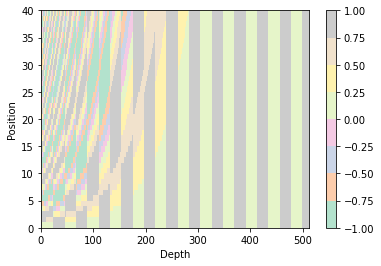

In [77]:
# 문장의 길이 40, 임베딩 차원 512인 행렬 만들기
sample_pos_encoding = PositionalEncoding(40, 512)

# visualize
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='Pastel2')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

---

# Attention mechanism

입력 시퀀스가 길어지면 출력 시퀀스의 정확도가 떨어지는 걸 보정하기 위해 등장한 메커니즘
- 디코더에서 출력 단어를 예측하는 매 시점(time step)마다 인코더에서 전체 입력문장을 다시 참고한다
    - 전체 입력 문장을 '동일한 비율'로 보는게 아니라 **해당 시점에서 예측해야할 단어와 연관이 있는 부분**을 더 **집중**해서

## Attention function
<img src='./img/attention.png'>

**Attention(Q, K, V) = Attention Value**
- 어텐션 함수는 주어진 query에 대해 각 key와의 유사도를 계산 -> 이 유사도를 value에 반영 -> 이 value들의 총합을 'Attention value 어텐션 값'으로 리턴
>   - t = 어텐션 메커니즘이 수행되는 디코더 셀의 현재 시점
>   - Q = Query : t 시점(어텐션마다 다름, t-1시점)의 디코더 셀의 은닉상태($s_t$)
>   - K = Keys : 모든 시점의 인코더 셀의 은닉상태($h_t$)
>   - V = Values : 모든 시점의 인코더 셀의 은닉상태
        - 예시) 구글링할때 검색키워드가 `Q`, 검색결과들이 `K`, 각 결과의 세부 내용이 `V`


---

# 트랜스포머에서 사용하는 3가지 Attention

<img src='./img/3attentions.png'>

- 1번 그림은 encoder에서, 2,3번 그림은 decoder에서 진행됨

>[Encoder] Encoder self-attention : Q = K = V<br>
> - 인코더의 입력으로 들어간 문장 내 단어간의 유사도를 구함<br>
>
> [Decoder] Masked Decoder self-attention : Q = K = V<br>
> - 단어를 1개씩 생성하는 디코더가 생성된 앞 단어들과의 유사도를 구함
>
> [Decoder] Encoder-Decoder attention : Q : decoder's vectors, K = V : Encoder's vectors<br>
> - 디코더가 잘 예측하도록 인코더에 입력된 단어들과의 유사도를 구함


<img src='./img/transformer_attention_overview.png' width=80% height=80%>

- 그림을 보면 3가지 attention이 일어나는 위치를 볼수 있음
- 박스 안을 보면 'Multi-head'라는 이름이 붙여져있는데 트랜스포머가 어텐션을 **병렬적으로** 수행한다는걸 의미


- 여기에서 사용되는 Q, K, V는 트랜스포머의 여러 연산을 거친 정보를 함축한 '**단어 벡터**'

---

## Self-Attention

**Q, K, V가 동일한 경우**
- 벡터의 출처가 동일하다(벡터의 값이 동일X)
- 현재 문장 내의 단어간의 유사도를 구하는 경우임

> [트랜스포머 셀프어텐션]<br>Q : 입력 문장의 모든 단어 벡터들<br>
> K : 입력 문장의 모든 단어 벡터들<br>
> V : 입력 문장의 모든 단어 벡터들<br>

<a href='https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html'><img src='./img/self-attention.png'></a>

- 여기에서 'it'은 'street'인지 'animal'인지를 알아내기위해 입력문장내의 단어들끼리의 유사도를 구한다 => Attention function의 역할!
    - 이 유사도를 알수 있는 지표 = 'Attention Value'

다시 정리하면,
- 어텐션 함수는 Q에 대해 모든 K와의 유사도를 각각 구하고, K에 매핑되어있는 V에 각 유사도를 가중치로 반영한다.
- 이 유사도가 반영된 V를 모두 가중합해서 리턴하는데 이 값이 **Attention Value**

---

# Transformer - Scaled dot-product Attention
트랜스포머는 **scaled dot-product attention**을 사용
$$Attention(Q, K, V) = softmax({QK^T\over{\sqrt{d_k}}})V$$

**[Key concept 3]**
1. `Q`, `K`, `V`는 단어 벡터를 행으로 하는 문장행렬
2. 벡터의 **내적(dot product)**는 벡터의 유사도를 의미
3. 특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링(scaling)때문

**[process]**
1. 문장행렬에 가중치 행렬을 곱해서 **Q행렬**, **K행렬**, **V행렬**을 구함
<img src='./img/transformer12.png'>


2. Attention score 행렬 구함
    - Q행렬 ● K행렬
<img src='./img/transformer15.png'>


3. Attention score를 $\sqrt{d_{k}}$로 나눈뒤 Attention distribution구하고(softmax, 이 값들이 attention weights) V행렬 내적곱
<img src='./img/attention_function_formular.png'>
          

In [78]:
# scaled dot-product attention
def scaled_dot_product_attention(query, key, value, mask):
    '''
    ===
    query size: (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    key size : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    value size : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    padding_mask : (batch_size, 1, 1, key의 문장 길이)
    ===
    (논문에서 사용한 수치)
    num_heads = 8
    d_model = 512
    d_k = d_model / num_heads = 64
    ===
    '''
    # Attention score matrix : Q x K
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # scaling : d_k 루트값으로 나누기
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # masking : attention score matrix의 마스킹할 위치에 매우 작은 음수를 넣는다
    # 매우 작은 값이라 소프트맥스 함수를 지나면 행렬 해당 위치의 값이 0이 됨
    if mask is not None:
        logits += (mask * -1e9)
        
    # softmax : 마지막 차원인 key의 문장길이 방향으로 수행됨
    # attention_weights : (batch_size, num_heads, query의 문장 길이, key의 문장길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # Attention value : attention weights x V mastrix
    # output : (batch_size, num_heads, query의 문장길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)
    
    return output, attention_weights

In [79]:
# scaled_dot_product_attention test

# 임의의 Q, K, V 행렬 생성
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

- `temp_q`는 `temp_k`의 두번째 값과 일치!
    - attention distribution, attention value 어떻게 나오는지 확인

In [80]:
# scaled_dot_product_attention test

# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print('attention distribution :', temp_attn) # attention distribution(어텐션 가중치의 나열)
print('attention value :', temp_out)  # attention values

attention distribution : tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
attention value : tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


Q가 K의 두번째 값과 일치했기때문에 
- 어텐션 분포는 [0. 1. 0. 0.]: 두번째 값이 1로, 
- 어텐션 value는 V의 두번째 값 [10.  0.]이 출력됨

# Multi-head Attention
트랜스포머는 `num_heads` 변수를 사용해서 병렬로 어텐션을 수행함

<img src='./img/transformer17.png'>

- $d_{model}$ 차원을 num_heads로 나눠서 $d_{model}/num\_heads$ 차원을 갖는 Q, K, V에 대해 num_heads개의 병렬 어텐션을 수행함
- 그림에서 $a_{num\_heads}$(어텐션 값 행렬)을 **Attention head 어텐션 헤드**라고 부름


**병렬 어텐션 효과**
- 여러 시점의 시각으로 정보들을 수집할수 있다

<img src='./img/transformer19.png'>

- 트랜스포머의 초기입력 문장행렬의 크기는 문장의 길이를 행으로, `d_model`을 열로 가짐
- 어텐션헤드를 모두 연결한 행렬에 또다른 가중치 행렬 $W^o$를 곱합


**Multi-head attention 구현 단계**
1. WQ, WK, WV에 해당하는 d_model 크기의 Dense layer를 통과
2. 지정된 num_heads만큼 나눈다(split)
3. scaled dot-product attention
4. 나눠졌던 헤드를 concatenate
5. Wo에 해당하는 dense layer 통과

In [81]:
# multi-head attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        #d_model을 num_headsfh 나눈 값 : 논문 기준 64
        self.depth = d_model // self.num_heads
        
        # WQ, WK, WV에 해당하는 dense layer
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        # Wo에 해당하는 dense layer
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    # num_heads 개수만큼 q, k, v를 split
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        # 1. WQ, WK, WV에 해당하는 d_model 크기의 Dense layer를 통과
        '''
        q : (batch_size, query의 문장 길이, d_model)
        k : (batch_size, key의 문장 길이, d_model)
        v : (batch_size, value의 문장 길이, d_model)
        참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있음
        '''
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. head나누기
        '''
        q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        '''
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. scaled dot-product attention
        '''
        (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        '''
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # shape 변경 : (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. concatenate heads : (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 5. Wo dense layer 통과 : (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs

# Masking
**Masking**은 특정 값을 가려서 실제 연산에 방해가 되지 않도록 하는 기법
- 트랜스포머에서는 2가지 마스킹을 사용

## Padding Masking
- padding token을 사용
- '패딩'은 문장의 길이가 다를때, 모든 문장의 길이를 동일하게 하는 과정에서 **정한 길이보다 짧은 문장의 경우 '0'을 채워서 문장의 길이를 맞추는** NLP 전처리 방법
- **[Encoder] Encoder self-attention**에서 사용

<img src='./img/padding_token.png'>

- 위 그림은 keras의 `pad_sequences()`를 사용해서 패딩하는 과정을 시각화한 그림
- 숫자 0은 의미있는 단어가 아니므로 연산에서는 제외해야함
- 트랜스포머에서 사용한 mask값을 받아서 아주 작은 값을 곱한뒤 어텐션스코어행렬에 더해주는건 패딩을 연산에서 제외시키기 위함

<img src='./img/pad_masking2.png'>

👉softmax함수를 통과한 뒤: <img src='./img/pad_masking3.png'>



In [82]:
# padding masking function
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length=key 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [83]:
# mask test
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


- 0인 부분만 '1'로 표시된 벡터를 얻을수 있다

## Look-ahead masking, 다음 단어 가리기
트랜스포머는 전체 문장이 문장행렬로 입력되기때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할수 있음  
but, **이전 단어만 참고해서 다음 단어를 예측**하는 훈련을 하는게 목적!

**Look-ahead masking** : 다음에 나올 단어는 참고하지 않도록 가리는 마스킹 기법

<a href='https://www.youtube.com/watch?v=xhY7m8QVKjo'><img src='./img/look_ahead_masking.png' width=80% height=80%></a>

- 어텐션을 수행할때 Query 단어 뒤에 나오는 Key 단어는 마스킹 
- **[Decoder] Masked Decoder self-attention**에서 사용

In [84]:
# decoder의 첫번째 sublayer에서 미래 토큰을 mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [85]:
# mask test
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [86]:
# mask test2 - 0 padding이 포함된 경우
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


- 숫자 0은 무조건 1로 채워진다

---

# Encoder layer 구현

<img src='./img/encoder.png' width=70% height=70%>
<img src='./img/encoder_detail.png' width=60% height=60%>

하나의 인코더층은 2개의 sublayer로 나눠짐
- Self attention + Feed Forward Neural Network
    - 셀프어텐션은 Multi head attention으로 병렬로 일어남
    

In [87]:
# 1개의 Encoder layer
def encoder_layer(units, d_model, num_heads, dropout, name='encoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    
    # padding mask
    padding_mask = tf.keras.Input(shape=(1,1,None), name='padding_mask')
    
    # Sublayer 1 : Multi head attention layer(self attention)
    attention = MultiHeadAttention(
        d_model, num_heads, name='attention')({
        'query': inputs,
        'key' : inputs,
        'value': inputs,
        'mask' : padding_mask
    })
    
    # Dropout + Residual connection & Layer Normalization()
    # sublayer 1 어텐션의 결과의 훈련을 돕기위한 과정
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)
    
    # Sublayer 2 : Feed Forward NN (2개의 완전연결층)
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # Dropout + Residual connection & Layer Normalization()
    # sublayer 2 dense layer 결과의 훈련을 돕기위한 과정
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    
    return tf.keras.Model(inputs=[inputs, padding_mask],
                         outputs=outputs, name=name)

# Encoder
트랜스포머는 `num_layers` 개수의 인코더 층을 쌓는다

- encoder layer + embedding layer + positional encoding = Encoder

---

💡 **[embedding]**
- 사람이 사용하는 언어(자연어)를 컴퓨터가 이해할 수 있는 언어(숫자) 형태인 **vector(벡터)로 변환한 결과 혹은 일련 과정**
- 역할 : (1) 단어 및 문장 간 관련성 계산, (2) 의미적/문법적 정보 함축


[REF] [blog](https://velog.io/@choonsik_mom/%EB%8B%A4%EC%96%91%ED%95%9C-NLP-Embedding-%EA%B8%B0%EB%B2%95.araboja) 

---

- 아래 코드에서는 `tf.keras.layers.Embedding`을 사용
    - 임베딩 방식이 여러개가 있는데, 케라스 임베딩 레이어는 어떤 방식을 사용할까?
    - [tf doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding#output-shape)에서는 별다른 설명을 찾지 못했다.
    
> **처음에 무작위로 초기화된 상태에서 정수 word를 정해진 크기의 벡터로 바꿔서 다음 layer에 전달하고, 학습단계에서는 역전파되는 기울기를 바탕으로 해당 word의 임베딩 값을 조정 -> 주변 문맥을 반영하지 않음** 참고: [블로그](https://heegyukim.medium.com/keras-embedding%EC%9D%80-word2vec%EC%9D%B4-%EC%95%84%EB%8B%88%EB%8B%A4-619bd683ded6), [StackExchange](https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work)

- ✅ 트랜스포머 논문 천천히 읽어보기


In [88]:
# Encoder
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='encoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    
    # padding mask
    padding_mask = tf.keras.Input(shape=(1,1,None), name='padding_mask')
    
    # Embedding layer
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # Positional encoding
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # num_layers만큼 layer 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(units=units,
                               d_model=d_model,
                               num_heads=num_heads,
                               dropout=dropout,
                               name='encoder_layer_{}'.format(i),
                               )([outputs, padding_mask])
        
    return tf.keras.Model(inputs=[inputs, padding_mask],
                         outputs=outputs, name=name)

---

# Decoder layer 구현
디코더는 3개의 sublayer로 구성

<img src='./img/decoder_layer.png' width=80% height=80%>

- **Self-attention + Encoder-Decoder Attention + Feed forward**
    - Encoder-Decoder Attention은 Q:decoder vector, K,V: encoder vector!
        - 여기에서 encoder가 입력문장의 정보를 decoder에 전달함

<img src='./img/decoder_layer_detail.png'>

- attention 모두 **multi-head attention으로 병렬처리**!

In [89]:
# 1개의 decoder layer
def decoder_layer(units, d_model, num_heads, dropout, name='decoder_layer'):
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    
    # Sublayer 1 : Look-ahead mask
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    
    # Sublayer 2 : Padding mask
    padding_mask = tf.keras.Input(shape=(1,1,None), name='padding_mask')
    
    # Sublayer 1 : Multi-head attention(masked self attention)
    attention1 = MultiHeadAttention(d_model, num_heads, name='attention_1')(inputs={
        'query': inputs,
        'key' : inputs,
        'value': inputs,
        'mask' : look_ahead_mask
    })
    
    # Residual connection + LayerNormalization
    # sublayer 1 어텐션의 결과의 훈련을 돕기위한 과정
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    # Sublayer 2 : masked Multi-head attention(Encoder-Decoder attention)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name='attention_2')(inputs={
        'query': attention1,
        'key' : enc_outputs,
        'value' : enc_outputs,
        'mask' : padding_mask
    })
    
    # Dropout + Residual connection + LayerNormalization
    # sublayer 2 어텐션 결과의 훈련을 돕기위한 과정
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    # Sublayer 3 : Feed forward NN(Dense layer)
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # Dropout + Residual connection + LayerNormalization
    # sublayer 3 결과의 훈련을 돕기위한 과정
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                         outputs=outputs, name=name)

# Decoder

In [90]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    
    # look-ahead mask
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    
    # padding mask
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # Embedding layer
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # Positional encoding
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    # Dropout
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # num_layers만큼 layer 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(units=units,
                               d_model=d_model,
                               num_heads=num_heads,
                               dropout=dropout,
                               name='decoder_layer_{}'.format(i),
                               )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                         outputs=outputs,
                         name=name)

---

# Transformer

위에서 만든 함수들을 모두 합한 트랜스포머 함수 

In [91]:
def transformer(vocab_size, num_layers, units, 
                d_model, num_heads, dropout, name='transformer'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    
    # padding mask for encoder
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1,1,None),
        name='enc_paddint_mask')(inputs)
    
    
    # look-ahead mask for decoder
    # decoder에서 미래토큰을 마스크하기위해 사용
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    # padding mask for decoder
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1,1,None),
        name='dec_padding_mask')(inputs)
    
    # Encoder
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout)(inputs=[inputs, enc_padding_mask])
    
    # Decoder
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name='outputs')(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

---

# 모델 생성

In [92]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 5 # 인코더와 디코더의 층의 개수 : 논문엔 6이지만 5로 해본다!
D_MODEL = 256  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8  # Multi-head attention의 헤드 수 
UNITS = 512    # Fead forward NN의 은닉층 크기
DROPOUT = 0.3  # 드롭아웃 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    name='transformer')

model.summary()

(1, 8175, 256)
(1, 8175, 256)
Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_paddint_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    4728320     inputs[0][0]                     
                                                          

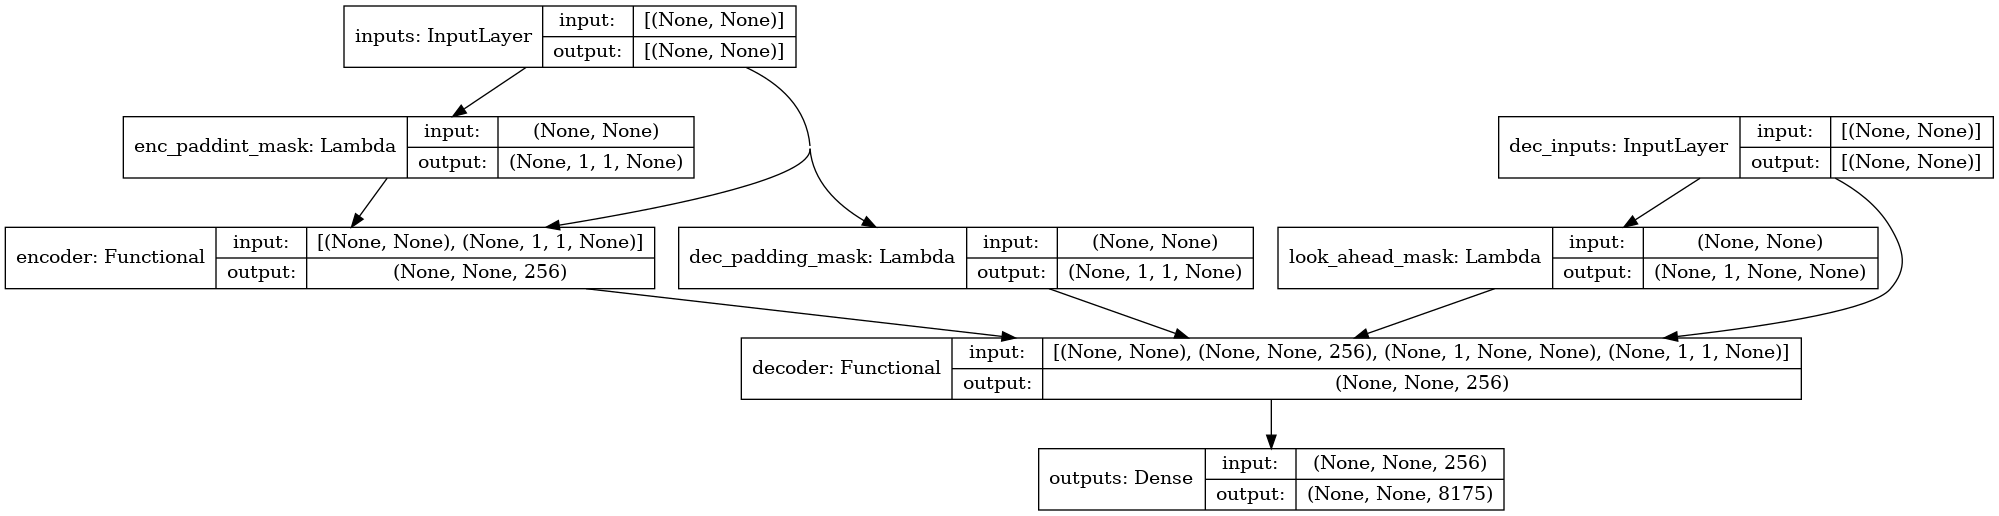

In [93]:
tf.keras.utils.plot_model(
    model, to_file='transformer.png', show_shapes=True)

# Loss function
- label인 sequence에 패딩이 되어있으니 loss 계산할때 패딩마스크 적용해야함!

In [94]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

# Custom Learning rate
**커스텀 학습률 스케줄링(Custom Learning rate Scheduling)**
- 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법
- 논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저 사용

[REF] [tf doc](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule)

In [95]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

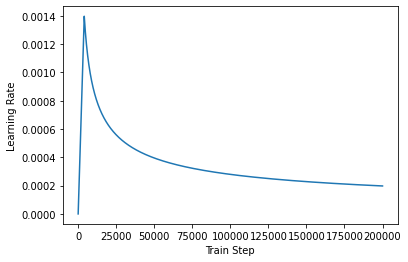

In [96]:
# 방금 정의한 커스텀 학습률 스케줄링 계획 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Compile model

In [98]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [99]:
print('GPU train')
with tf.device('/GPU:0'):
    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

GPU train


---

# ===STEP 3. 모델 훈련===

# Train model

In [100]:
EPOCHS = 50

with tf.device('/GPU:0'):
    model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 40s 103ms/step - loss: 1.4510 - accuracy: 0.0211
Epoch 2/50
185/185 [==============================] - 19s 104ms/step - loss: 1.2033 - accuracy: 0.0313
Epoch 3/50
185/185 [==============================] - 19s 103ms/step - loss: 1.0421 - accuracy: 0.0496
Epoch 4/50
185/185 [==============================] - 19s 102ms/step - loss: 0.9799 - accuracy: 0.0504
Epoch 5/50
185/185 [==============================] - 19s 102ms/step - loss: 0.9425 - accuracy: 0.0516
Epoch 6/50
185/185 [==============================] - 19s 103ms/step - loss: 0.9195 - accuracy: 0.0529
Epoch 7/50
185/185 [==============================] - 19s 102ms/step - loss: 0.8982 - accuracy: 0.0538
Epoch 8/50
185/185 [==============================] - 19s 102ms/step - loss: 0.8758 - accuracy: 0.0549
Epoch 9/50
185/185 [==============================] - 19s 102ms/step - loss: 0.8538 - accuracy: 0.0562
Epoch 10/50
185/185 [==============================] - 19s 102ms/step - l

---

# ===STEP 4. 모델 테스트===

# Test Chatbot 
**예측(inference) 단계**

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가
3. 패딩 마스킹과 룩 어헤드 마스킹 계산
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [101]:
# 예측 함수
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가
        # 이 output_sequence는 다시 디코더의 입력이 됨
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [102]:
# 챗봇의 대답을 얻는 sentence_generation()함수
# 임의의 입력 문장에 대해서 decoder_inference() 함수를 호출
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('Input : {}'.format(sentence))
    print('Output : {}'.format(predicted_sentence))

    return predicted_sentence

- 챗봇데이터 내용을 참고해서 질문테스트

In [103]:
# chatbot test1
sentence_generation('오늘 기분이 안좋아')

Input : 오늘 기분이 안좋아
Output : 이젠 그녀를 놓아주세요 .


'이젠 그녀를 놓아주세요 .'

In [104]:
# chatbot test2
sentence_generation("나 그 사람 좋아하는 것 같아")

Input : 나 그 사람 좋아하는 것 같아
Output : 사랑은 쟁취하는거예요 .


'사랑은 쟁취하는거예요 .'

In [105]:
# chatbot test3
sentence_generation("점심 뭐 먹지?")

Input : 점심 뭐 먹지?
Output : 회원정보 찾기를 해보세요 .


'회원정보 찾기를 해보세요 .'

In [106]:
# chatbot test4
sentence_generation("이제 하나도 안 아프다")

Input : 이제 하나도 안 아프다
Output : 더 많이 배웠길 바라요 .


'더 많이 배웠길 바라요 .'

In [107]:
# chatbot test5
sentence_generation("에휴")

Input : 에휴
Output : 더 많이 배웠길 바라요 .


'더 많이 배웠길 바라요 .'

In [108]:
# chatbot test6
sentence_generation("한숨만 나와")

Input : 한숨만 나와
Output : 제가 있잖아요 .


'제가 있잖아요 .'

In [109]:
# chatbot test7
sentence_generation("비온다!")

Input : 비온다!
Output : 맛있게 드세요 .


'맛있게 드세요 .'

In [110]:
# chatbot test8
sentence_generation("재밌는 일을 해보고 싶다")

Input : 재밌는 일을 해보고 싶다
Output : 더 많이 믿어주세요 .


'더 많이 믿어주세요 .'

In [112]:
# chatbot test9
sentence_generation("날씨가 참 좋다!")

Input : 날씨가 참 좋다!
Output : 잘할 수 있을 거예요 .


'잘할 수 있을 거예요 .'

In [113]:
# chatbot test10
sentence_generation("춤을 춰야겠어")

Input : 춤을 춰야겠어
Output : 잘할 수 있을 거예요 .


'잘할 수 있을 거예요 .'

In [114]:
# chatbot test11
sentence_generation("친구랑 대화가 잘 통해서 신기해")

Input : 친구랑 대화가 잘 통해서 신기해
Output : 사랑은 쟁취하는거예요 .


'사랑은 쟁취하는거예요 .'

In [115]:
# chatbot test12
sentence_generation("역시 세상에서 사랑이 최고야")

Input : 역시 세상에서 사랑이 최고야
Output : 좋은 소식 아닌가요 ?


'좋은 소식 아닌가요 ?'

- 부정적인 표현에 대해서는 꽤 그럴싸한 답변을 내놓는데, 일상 표현에 대해서는 조금 어색한 대답을 한다.
- 레이블 분포를 봐야겠다

> label : 일상다반사=0, 이별(부정)=1, 사랑(긍정)=2

In [121]:
# 레이블 분포 확인 

# 데이터 레이블별로 추출
daily = df[df['label'] == 0]
neg = df[df['label'] == 1]
pos = df[df['label'] == 2]

daily, neg, pos

(                    Q            A  label
 0              12시 땡!   하루가 또 가네요.      0
 1         1지망 학교 떨어졌어    위로해 드립니다.      0
 2        3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
 3     3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
 4             PPL 심하네   눈살이 찌푸려지죠.      0
 ...               ...          ...    ...
 5285             힘내야지       응원합니다!      0
 5286      힘든 것 좀 끝났으면   다 지나갈 거예요.      0
 5287     힘든 시기가 지나갔으면   다 지나갈 거예요.      0
 5288   힘든 데도 날 도와준 사람  잊지말고 보답하세요.      0
 5289           힘차게 시작       응원합니다!      0
 
 [5290 rows x 3 columns],
                          Q                          A  label
 5290     1000일 만난 여자친구와 이별         더 오래 만날 사람 만날 거예요.      1
 5291       10년 연애. 헤어졌습니다.              더 공허함이 크시겠네요.      1
 5292  10년 연애사 되돌아보니 다 부질없네           더 좋은 사람 만나실 거예요.      1
 5293              10년 연예의끝               더 마음이 허하겠어요.      1
 5294           10년만나다 헤어지네  충분히 슬퍼하고 충분히 아파하다가 이겨내세요.      1
 ...                    ...                        ...    ...
 8855                 

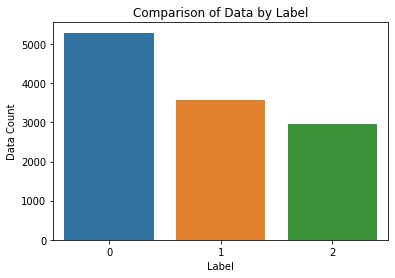

In [117]:
import seaborn as sns

sns.countplot(x='label', data=df)

plt.title('Comparison of Data by Label')
plt.xlabel('Label')
plt.ylabel('Data Count')

plt.show()

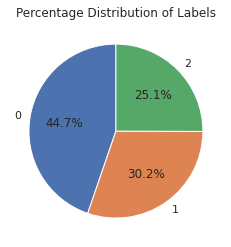

In [124]:
# Calculate the percentage of each label
label_percentages = df['label'].value_counts(normalize=True) * 100

# Use Matplotlib to create a pie chart
plt.pie(label_percentages, labels=label_percentages.index, autopct='%1.1f%%', startangle=90)

# Add title to the pie chart
plt.title('Percentage Distribution of Labels')

plt.show()

- 일상 질문의 비율이 훨씬 더 많다.

# ===SUMMARY===

노드에서는 트랜스포머 모델을 구현하는 부분에서는 굉장히 힘들었고, 오늘 프로젝트 진행에서는 데이터를 가져오는 부분과 역시 EDA에서 힘들었다. 이론을 공부하는 것도 필요하고, 데이터를 가져와서 실습해보는 것도 필요한데 여전히 공부할 지점이 많다. 무엇보다 NLP의 플로우를 완전히 잊은 상태라 분명 이전에 공부했던 내용일텐데 음절, 어절에 대한 정의부터 다시 파악해야했다. NLP 다시 천천히 공부해보자!

# ===KPT===

**[KEEP]**
- 포기하지않고 마무리지었다.
- 프로젝트는 강훈님과 대화하면서 진행했는데 사실 생각보다 집중이 더 잘됬고, 모르는 지점을 바로 확인해보고, 서로의 코드를 비교분석해볼수 있었다. 보통은 나 혼자서 집중해서 프로젝트를 진행하는데 신기했다.

**[PROBLEM]**
- 데이터를 불러오는 과정에서 404에러가 발생해서 한참이나 헤맸다.
- NLP 데이터 전처리 플로우에 대한 이해가 매우 부족했다.

**[TRY]**
- NLP 프로젝트를 하나 더 진행하면서 다시 천천히 복습해본다.
- 이론에 대한 공부가 필요한데, 정은님이 주셨던 자료를 공부해본다.... (꼭..)

